**Author -** Amparo Godoy Pastore <br>
**Date -** June 19th, 2024 <br>
**Course -** CAP6673 Data Mining and Machine Learning <br>

# Dimensionality Reduction and Classification on Colon Cancer data 

> In this notebook we work with the `colon.csv` file, which contains gene data from each patient. The dataset includes various gene expression measurements (features) and a label indicating the stage information.
> We apply PCA and KPCA to this real-world data for dimensionality reduction and classification. 

## Table of Contents
* [Preliminaries](#zero)
* [Part 1. Principal Component Analysis (PCA)](#part-1) <br>
      [1.1 PCA from Scratch](#1-1) <br>
      [1.2 PCA with scikit-learn](#1-2)
* [Part 2. Kernel PCA (KPCA)](#part-2) <br>
      [2.1 KPCA with RBF Kernel](#2-1) <br>
      [2.2 KPCA with Polynomial Kernel](#2-2) <br>
      [2.3 KPCA with Linear Kernel](#2-3) <br>
      [2.4 Combining Kernels](#2-4)
* [Part 3. Testing and Evaluation](#part-3) <br>
      [3.1 Applying PCA and KPCA to the Test Dataset](#3-1) <br>
      [3.2 Covariance Matrix Analysis](#3-2) <br>
      [3.3 Classification Experiment](#3-3) <br>
* [Conclusion](#last)

## Preliminaries <a class="anchor" id="0"></a>

Importing necessary libraries.

In [194]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

**Dataset**

In this notebook we work with the `colon.csv` file, which contains gene data from each patient. The dataset includes various gene expression measurements (features) and a label indicating the stage information.

This code loads the dataset.

In [195]:
data = pd.read_csv("colon.csv")
data.head()

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,Label
0,5785.164636,5723.093854,5783.766645,5779.013477,489.296704,324.054217,539.903964,3629.183557,3724.526515,304.482349,...,4.193972,0.0,0.559196,1.677589,0.0,5.871560,31.874185,78.287473,11948.625524,0
1,11098.460818,11036.758267,11115.828944,9275.036153,788.421493,570.862867,906.113397,6589.146933,6772.654892,873.662426,...,7.541423,0.0,0.000000,22.624269,0.0,31.993916,38.392699,289.544937,7432.643666,2
2,4584.125996,4693.036117,4637.873848,24842.822894,489.388335,636.487719,299.856437,983.019922,951.902745,623.757965,...,8.486503,0.0,0.000000,43.846932,0.0,18.387423,46.675766,246.108585,22397.295634,4
3,6807.476333,6720.276568,6762.758505,11207.304129,831.548347,536.207416,534.378050,3890.451077,3952.242985,581.331770,...,10.163143,0.0,0.000000,2.642417,0.0,9.756617,61.182120,198.587811,14206.447579,1
4,8531.078761,8584.934503,8664.659815,12816.725853,1286.893535,756.567343,1042.308506,3831.988900,4011.194469,881.446815,...,12.934785,0.0,2.822135,16.462454,0.0,13.640319,61.381435,360.057383,15172.502999,4


**Classifier**

Defining a custom classifier function that uses distance to classify test data points based on the closest training data points.

In [196]:
# Function to calculate distance between two points
def dis(x1, x2):
    return np.linalg.norm(x1 - x2)

# Function to perform classification 
def myclassifier(Train, Trainlabel, Test):
    """
    Perfom Classification

    Parameters:
    - Train: the training data.
    - Trainlabel: the training labels.
    - Test: the testing data.

    Returns:
    - Predictions.
    """
    pred = []

    for testpoint in Test:
        pred_dis = []
        for trainpoint in Train:
            pred_dis.append(dis(testpoint, trainpoint))

        pred.append(Trainlabel[np.argmin(pred_dis)])

    return np.array(pred)

**Accuracy**

Function to calculate the accuracy of the classifier by comparing true labels with predicted labels.

In [197]:
def calculate_accuracy(true_labels, predicted_labels):
    # Ensure that the true labels and predicted labels have the same length
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Length of true_labels and predicted_labels must be the same.")

    # Count the number of correct predictions
    correct_predictions = sum(1 for true, predicted in zip(true_labels, predicted_labels) if true == predicted)

    # Calculate accuracy as the ratio of correct predictions to total predictions
    accuracy = correct_predictions / len(true_labels)

    return accuracy

**Evaluation**

Function to evaluate the classifier's performance on projected data and print the accuracy of the specified method. 

In [198]:
def evaluate_projection(proj_train, proj_test, method_name):
    y_pred = myclassifier(proj_train, y_train, proj_test)
    accuracy = calculate_accuracy(y_test, y_pred)
    print(f"{method_name}: {round(accuracy * 100, 2)}%")
    return y_pred

## Part 1. Principal Component Analysis <a class="anchor" id="part-1"></a>

### 1.1 Implement PCA from Scratch: <a class="anchor" id="1-1"></a>

**Covariance matrix, eigenvalues, and eigenvectors:**

The code below includes functions to compute the covariance matrix, eigenvalues, and eigenvectors for Principal Component Analysis.

In [199]:
def cov_matrix(data):
    n = len(data) - 1     
    return (1/n) * (data.T @ data)

def get_eigenval(m):
    e, _ = np.linalg.eig(m)
    return e

def get_eigenvect(m):
    _, e = np.linalg.eig(m)
    return e

**Implementation of PCA from scratch:**

The following code implements the `PCA` function from scratch. Unlike the sklearn method, this implementation performs the calculation of the number of components based on the desired variance to be retained. The `k` components are not explicitly returned, but can be accessed from the returned projected data by indexing it with `[1]` and calling `.shape()`

In [200]:
def custom_PCA(D, alpha):
    """
    Principal Component Analysis (PCA) 

    Parameters:
    - D: input data as a numpy array
    - alpha: minimum variance to be retained (e.g., 0.95)

    Returns:
    - Projected data.
    - Mean.
    - Reduced eigen vectors.
    """
    mean = np.mean(D, axis=0) # mean vector
    centered = D - mean # center data
    # covariance matrix
    cov_m = cov_matrix(D)
    # eigenvalues and vectors
    eigenvals = get_eigenval(cov_m)
    eigenvects = get_eigenvect(cov_m)
    # sort them
    indx = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[indx]
    eigenvects = eigenvects[:, indx]
    # find total variance
    total_var = np.sum(eigenvals)
    var_ex = np.cumsum(eigenvals)/total_var
    k = np.argmax(var_ex >= alpha) + 1
    # reduce dimensions
    reduced_eig_vectors = eigenvects[:,:k]
    # project data
    proj = centered @ reduced_eig_vectors
    
    return proj, mean, reduced_eig_vectors

**Reducing the dimensionality of the features in the `colon.csv` dataset:**

Now, we are applying the custom PCA function to the `colon.csv` dataset to reduce the dimensionality of its features. First, we load the data and convert it to a numpy array. The last column contains the labels, so we drop it before applying PCA.

In [201]:
df = data.iloc[:, :-1].to_numpy() # dropping last column because that is the label
print(f"Shape of the data prior to dimensionality reduction: {df.shape}")

Shape of the data prior to dimensionality reduction: (467, 1881)


In [202]:
alpha = .95 
# Applying the custom_PCA function to the dataset
proj, mean, reduced_eigvectors = custom_PCA(df, alpha)
# Results
print(proj)
print(f"\nNumber of principal components: {proj.shape[1]}\n"
      f"Capturing at least {alpha*100}% of the variance")

[[  58877.10593624+0.j   65464.54413675+0.j   46374.0989389 +0.j
    78460.87652231+0.j]
 [ -11092.07290379+0.j  -62629.10262083+0.j   56544.98734569+0.j
    -8413.93760738+0.j]
 [  -7054.46794881+0.j  -15071.12991911+0.j  -50975.85541947+0.j
   -68595.98138461+0.j]
 ...
 [ -26579.52696653+0.j  -80274.18666364+0.j   14475.73478585+0.j
    30396.96007795+0.j]
 [ -45378.08848863+0.j -112518.00170035+0.j -102717.52737208+0.j
   -36757.44337968+0.j]
 [   1244.02778273+0.j   68803.08262944+0.j  -99008.14167868+0.j
    -4698.58704204+0.j]]

Number of principal components: 4
Capturing at least 95.0% of the variance


### 1.2 PCA using scikit-learn: <a class="anchor" id="1-2"></a>

**Implementation of PCA using scikit-learn:**

The PCA function from the `sklearn.decomposition` module requires we specify a number of components. To compare later with the custom PCA function results, we will try the PCA function with k components in the range (1, 21).

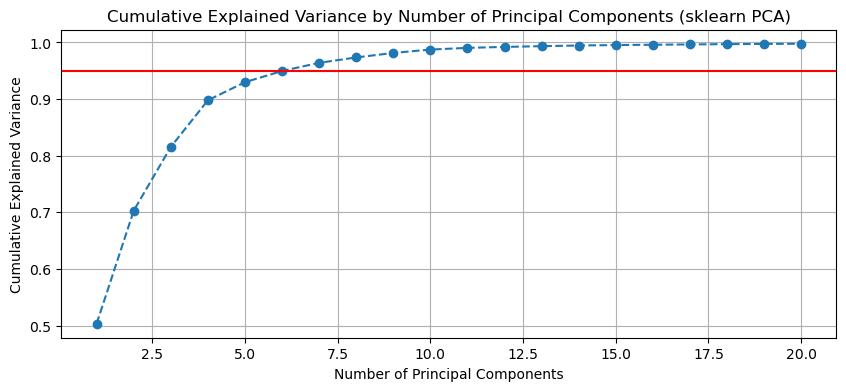

Variance retained with
1 components: 0.5
2 components: 0.7
3 components: 0.82
4 components: 0.9
5 components: 0.93
6 components: 0.95
7 components: 0.96
8 components: 0.97
9 components: 0.98
10 components: 0.99


In [203]:
from sklearn.decomposition import PCA

# We are saving the explained variance for different numbers of components to plot it later
explained_variance_ratios = []
components_range = range(1, 21) # We're evaluating the retained variance explained by k components, k in range(1, 21)

for i in components_range: # Fitting the model for each k, and saving results
    pca = PCA(n_components=i)
    pca.fit(df) 
    explained_variance_ratios.append(sum(pca.explained_variance_ratio_))

# Now we plot cumulative explained variance
plt.figure(figsize=(10, 4))
plt.plot(components_range, explained_variance_ratios, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')  # Add a horizontal line at 95% variance to compare with custom PCA
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components (sklearn PCA)')
plt.grid(True)
plt.show()

# We also print variance retained for each number of components for reference (only until k=10)
print("Variance retained with")
for i, var in zip(components_range[:10], explained_variance_ratios):
    print(f"{i} components: {round(var, 2)}")

**Comparison:**

The custom PCA function retained at leasdt 95% of variance with 4 principal components. However, the `sklearn` PCA method needed 6 principal components to retain the same amount of variance. The 4 components in this last method, explained only 90% of the variance. 

## Part 2: Kernel PCA (KPCA) <a class="anchor" id="part-2"></a>

**Defining the kernel functions**

This code defines different types of kernel functions to calculate a similarity measure between two input vectors `x` and `y`.

1. **RBF Kernel (Gaussian Kernel)**: Computes the similarity using the radial basis function.
2. **Polynomial Kernel**: Computes the similarity as a polynomial function of the dot product of the input vectors.
3. **Linear Kernel**: Computes the similarity as the dot product of the input vectors.

 Combined:
1. **RBF + Polynomial Kernel**
2. **RBF + Linear Kernel**
3. **Polynomial + Linear Kernel**

Below are the implementations of these kernels.

In [204]:
def rbf_kernel(x, y, gamma=1.0):
    """ Gaussian or RBF Kernel """
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)

def poly_kernel(x, y, degree=2.0):
    """ Polynomial Kernel """
    return np.dot(x, y) ** degree
    
def linear_kernel(x, y):
    """ Linear Kernel """
    return np.dot(x, y)

# ----------- COMBINED -----------

def rbf_poly_kernel(x, y, gamma=1.0, degree=2.0):
    """ Combined RBF and Polynomial Kernel"""
    k1 = rbf_kernel(x, y, gamma=1.0)
    k2 = poly_kernel(x, y, degree=2.0)
    return k1 + k2

def rbf_linear_kernel(x, y, gamma=1.0):
    """ Combined RBF and Linear Kernel"""
    k1 = rbf_kernel(x, y, gamma=gamma)
    k2 = linear_kernel(x, y)
    return k1 + k2

def poly_linear_kernel(x, y, degree=2.0):
    """ Combined Polynomial and Linear Kernel"""
    k1 = poly_kernel(x, y, degree=degree)
    k2 = linear_kernel(x, y)
    return k1 + k2

**Kernel matrix function:**

This code defines a function to compute the kernel matrix for a given dataset using a specified kernel type.

In [206]:
def kernel_matrix(D, kernel_type, param, param2=2.0):
    """
    Compute Kernel Matrix

    Parameters:
    - D: input data as a numpy array
    - kernel_type: 'rbf', 'poly', 'linear', 'rbf+lin', 'rbf+poly', or 'poly+lin'
    - param: parameter for the kernel (e.g. gamma for RBF, degree for polynomial)
    
    Returns:
    - Kernel matrix
    """
    n = D.shape[0] # specify num of samples
    kernel_m = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if kernel_type == 'rbf':
                kernel_m[i,j] = rbf_kernel(D[i], D[j], param)
            elif kernel_type == 'poly':
                kernel_m[i,j] = poly_kernel(D[i], D[j], param)
            elif kernel_type == 'linear':
                kernel_m[i,j] = linear_kernel(D[i], D[j])
            elif kernel_type == 'rbf+poly':
                kernel_m[i,j] = rbf_poly_kernel(D[i], D[j], param, param2)
            elif kernel_type == 'rbf+lin':
                kernel_m[i,j] = rbf_linear_kernel(D[i], D[j], param)
            elif kernel_type == 'poly+lin':
                kernel_m[i,j] = poly_linear_kernel(D[i], D[j], param)
                
    return kernel_m    

**Implementation of KPCA from scratch:**

The following code implements the KPCA function from scratch. This implementation performs the calculation of the number of components based on the desired variance to be retained. 

In [207]:
def custom_KPCA(D, kernel_type, param, alpha, param2=0):
    """
    Kernel Principal Component Analysis

    Arguments:
    - D: input data of shape n samples by n features
    - kernel_type: 'rbf', 'poly', 'linear', 'rbf+lin', 'rbf+poly', or 'poly+lin'
    - param: i.e. gamma for RBF, degree for polynomial
    - alpha: target retained variance (e.g., .95)
    
    Returns: 
    - Projected data.
    - Mean.
    - Reduced eigen vectors.
    """
    n = D.shape[0]
    # 1) Compute kernel matrix
    kernel_m = kernel_matrix(D, kernel_type, param)

    # Ensure the kernel matrix is symmetric
    kernel_m = (kernel_m + kernel_m.T) / 2
    
    # 2) Center the kernel matrix
    one_n = np.ones((n, n)) / n
    mean = one_n.dot(kernel_m).dot(one_n)
    centered_kernel_m = kernel_m - one_n.dot(kernel_m) - kernel_m.dot(one_n) + mean # centered
    
    # 3) Find the eigen values and eigen vectors
    eig_values, eig_vectors = np.linalg.eig(centered_kernel_m)

    # Ensure eigenvalues and eigenvectors are real
    eig_values = np.real(eig_values)
    eig_vectors = np.real(eig_vectors)
    
    # 4) Sorting the eigen values and eigen vectors in descending order
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]

    # Find smallest k, s.t. retained variance >= alpha
    var_ratio = eig_values / np.sum(eig_values)
    cumulative_var_ratio = np.cumsum(var_ratio)
    k = np.argmax(cumulative_var_ratio >= alpha) + 1
    reduced_eig_vectors = eig_vectors[:, :k] # Dimensionality reduction :)

    # 5) Project the data onto the reduced components
    proj = np.dot(centered_kernel_m, reduced_eig_vectors)
        
    return proj, mean, reduced_eig_vectors

The following subsections run the KPCA models on the `colon.csv` data. The results show the number of components used by each model to retain at least 95% of the variance. 

### 2.1 KPCA with RBF Kernel: <a class="anchor" id="2-1"></a>



In [208]:
# Running the KPCA with RBF function algorithm on the colon.csv data
proj_rbf_KPCA, mean, reduced_eig_vec = custom_KPCA(df, kernel_type='rbf', param=1.0, alpha=.95)

# Displaying results
print(proj_rbf_KPCA)
print(f"\nNumber of principal components: {proj_rbf_KPCA.shape[1]}\n"
      f"Capturing at least {alpha*100}% of the variance")

[[-0.00141344  0.00079873  0.00506389 ...  0.00661038 -0.00853524
   0.00255072]
 [-0.00379328  0.00171028  0.00263746 ...  0.01637603 -0.01431578
   0.00257107]
 [ 0.01181998 -0.02208008 -0.00042019 ...  0.02063545 -0.03187372
  -0.00229608]
 ...
 [-0.00318289  0.02644951  0.0058325  ... -0.00599731 -0.03056413
   0.09333074]
 [-0.00144647  0.05957707  0.00130491 ...  0.0120232  -0.03009172
  -0.03106446]
 [-0.00023151 -0.03246531  0.00142937 ...  0.02915511 -0.03354089
   0.00543586]]

Number of principal components: 443
Capturing at least 95.0% of the variance


### 2.2 KPCA with Polynomial Kernel: <a class="anchor" id="2-2"></a>

In [209]:
# Running the KPCA with polynomial function algorithm on the colon.csv data
proj_poly_KPCA, mean, reduced_eig_vec = custom_KPCA(df, kernel_type='poly', param=2.0, alpha=.95)

# Displaying results
print(proj_poly_KPCA)
print(f"\nNumber of principal components: {proj_poly_KPCA.shape[1]}\n"
      f"Capturing at least {alpha*100}% of the variance")

[[-4.09079816e+22 -2.31059378e+22  2.13213971e+22 ...  1.03019557e+21
   6.34023011e+20 -1.15722969e+21]
 [ 5.03399880e+22 -1.27806671e+22  1.28214625e+21 ... -1.67904315e+21
  -6.84991597e+19  6.02431155e+20]
 [ 2.44548838e+22  1.22511138e+22 -1.37736486e+22 ... -2.52658781e+21
  -1.46739733e+21 -9.30442328e+20]
 ...
 [ 5.92454177e+22  3.48843605e+21  5.42089150e+21 ... -2.50952999e+21
   7.50631187e+20  7.02215595e+20]
 [ 7.14612826e+22  3.32593588e+22 -1.52423481e+22 ...  1.71223173e+21
   2.05852926e+21 -2.16266897e+21]
 [-2.64424962e+22  2.79508970e+22 -2.55128737e+21 ... -1.63644539e+21
  -2.25634543e+21 -1.08512740e+21]]

Number of principal components: 10
Capturing at least 95.0% of the variance


### 2.3 KPCA with Linear Kernel: <a class="anchor" id="2-3"></a>

In [210]:
# Running the KPCA with linear function algorithm on the colon.csv data
proj_lin_KPCA, mean, reduced_eig_vec = custom_KPCA(df, kernel_type='linear', param=0, alpha=.95)

# Displaying results
print(proj_lin_KPCA)
print(f"\nNumber of principal components: {proj_lin_KPCA.shape[1]}\n"
      f"Capturing at least {alpha*100}% of the variance")

[[-2.27065180e+11 -8.10307919e+10 -6.88996716e+10 ...  1.68611409e+10
   6.60110765e+09  4.87937460e+09]
 [ 1.62315844e+11 -9.98939641e+10 -1.26491459e+10 ...  1.48749398e+09
  -9.70774500e+09 -5.72492810e+09]
 [ 4.77672776e+10  5.52797934e+10  9.86352340e+10 ...  1.31759800e+10
  -3.01286910e+09 -5.74898223e+09]
 ...
 [ 2.28343671e+11 -3.00581295e+10 -2.33066126e+10 ... -1.18980219e+10
  -2.99599841e+09 -1.37054081e+10]
 [ 3.43443247e+11  1.33559749e+11  8.99284130e+10 ...  6.99680111e+09
  -1.81798072e+10  1.87391119e+10]
 [-1.66180278e+11  1.61145590e+11  5.51246309e+10 ...  2.59403424e+10
   9.80197624e+09 -3.76453385e+08]]

Number of principal components: 7
Capturing at least 95.0% of the variance


### 2.4 Combining Kernels: <a class="anchor" id="2-4"></a>

In [211]:
# Running the KPCA with linear function algorithm on the colon.csv data
proj_combined_KPCA, mean, reduced_eig_vec = custom_KPCA(df, kernel_type='rbf+poly', param=1.0, alpha=.95, param2=2.0)

# Displaying results
print(proj_combined_KPCA)
print(f"\nNumber of principal components: {proj_combined_KPCA.shape[1]}\n"
      f"Capturing at least {alpha*100}% of the variance")

[[-4.09079816e+22 -2.31059378e+22  2.13213971e+22 ...  1.03019557e+21
   6.34023011e+20 -1.15722969e+21]
 [ 5.03399880e+22 -1.27806671e+22  1.28214625e+21 ... -1.67904315e+21
  -6.84991597e+19  6.02431155e+20]
 [ 2.44548838e+22  1.22511138e+22 -1.37736486e+22 ... -2.52658781e+21
  -1.46739733e+21 -9.30442328e+20]
 ...
 [ 5.92454177e+22  3.48843605e+21  5.42089150e+21 ... -2.50952999e+21
   7.50631187e+20  7.02215595e+20]
 [ 7.14612826e+22  3.32593588e+22 -1.52423481e+22 ...  1.71223173e+21
   2.05852926e+21 -2.16266897e+21]
 [-2.64424962e+22  2.79508970e+22 -2.55128737e+21 ... -1.63644539e+21
  -2.25634543e+21 -1.08512740e+21]]

Number of principal components: 10
Capturing at least 95.0% of the variance


**Note**: The results show that the KPCA with linear kernel model reduced the dimensionality of the data the most (down to 7 components) while capturing at least 95% of the variance.

## Part 3: Testing and Evaluation <a class="anchor" id="part-3"></a>
This code splits `colon.csv` into Train and Test datasets using `sklearn`. We use an 80/20 split.

In [212]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, :-1].to_numpy() # data
y = data.iloc[:, -1].to_numpy() # labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of the Train data: {X_train.shape}")
print(f"Shape of the Test data: {X_test.shape}")

Shape of the Train data: (373, 1881)
Shape of the Test data: (94, 1881)


### 3.1 Applying PCA and KPCA to the Test Dataset <a class="anchor" id="3-1"></a>

The code in the followig subsections trains each of the PCA and KPCA models on `X_train` to identify the principal components, which are the directions of maximum variance in the dataset. During this training phase, the PCA algorithm computes the mean and reduced eigenvectors based on `X_train`. When testing the model on `X_test`, the test data is projected onto the principal components obtained during training. This projection transforms the test data into a new space defined by these principal components, effectively reducing its dimensionality while retaining the most important features. The output includes the projected data and the number of principal components used for both the train and test datasets.

**PCA Model**

In [213]:
# ------------- TRAIN -------------
proj_train_pca, mean_pca, red_eigv_pca = custom_PCA(X_train, alpha)

# Display Results
print("PCA (Train):\n")
print(proj_train_pca)
print(f"\nNumber of principal components: {proj_train_pca.shape[1]}")

# ------------- TEST -------------
X_test_centered = X_test - mean_pca
proj_test_pca = np.dot(X_test_centered, red_eigv_pca)

# Display Results
print("PCA (Test):\n")
print(proj_test_pca)
print(f"\n Number of principal components: {proj_test_pca.shape[1]}")

PCA (Train):

[[ -43982.97627044+0.j  -84102.95306431+0.j -129906.47407252+0.j
   -42307.69090108+0.j]
 [   1165.77235545+0.j   77451.68100044+0.j   14460.16825143+0.j
    53158.78701776+0.j]
 [  -9397.82977167+0.j  -89293.77631333+0.j -100779.07245706+0.j
   -57713.15318142+0.j]
 ...
 [ -65581.53985315+0.j -156869.55471605+0.j -159179.09676401+0.j
    10191.39505622+0.j]
 [  48365.41481998+0.j  -56781.00340467+0.j  113847.11723604+0.j
   -62841.09005304+0.j]
 [  22355.85242053+0.j -107799.57529491+0.j  132301.76540363+0.j
   -59015.97706473+0.j]]

Number of principal components: 4
PCA (Test):

[[ 5.27687533e+04+0.j  6.04222355e+04+0.j  5.73370164e+04+0.j
   1.61214747e+04+0.j]
 [-2.30527075e+04+0.j  4.24366379e+02+0.j -8.90774194e+03+0.j
   3.99506228e+04+0.j]
 [ 9.08273314e+04+0.j  3.13771608e+05+0.j -2.09680438e+04+0.j
  -5.46594020e+02+0.j]
 [-6.82659292e+04+0.j  3.57628450e+04+0.j  1.97590281e+04+0.j
  -4.68873930e+00+0.j]
 [-2.27109424e+05+0.j -2.65644320e+04+0.j -4.61818921e+04+

**KPCA models**

In [214]:
def KPCA_NewData(Y, X, eig_vector, kernel_type='rbf', param=1.0):
    """
    Project new data into the KPCA space defined by previously computed eigenvectors.

    Parameters:
    - Y: the new data to project (np.darray)
    - X: the original data used to fit the KPCA (np.darray)
    - eig_vectors: the eigenvectors obtained from KPCA (np.darray)
    - kernel_type: 'rbf', 'poly', or 'linear'
    - param: i.e. gamma for RBF, degree for polynomial

    Returns:
    - New data projected into the KPCA space (np.darray)
    """
    combined_data = np.vstack([Y, X])
    K_combined = kernel_matrix(combined_data, kernel_type, param)
    K = K_combined[:Y.shape[0], Y.shape[0]:]

    Z = np.dot(K, eig_vector)

    return Z

- **RBF**

In [215]:
# ------------- TRAIN -------------
proj_train_rbf, mean_rbf, red_eigv_rbf = custom_KPCA(X_train, kernel_type='rbf', param=1.0, alpha=.95)

# Display Results
print("RBF KPCA (Train)\n")
print(proj_train_rbf)
print(f"\nNumber of principal components: {proj_train_rbf.shape[1]}")

# ------------- TEST -------------
proj_test_rbf = KPCA_NewData(X_test, X_train, red_eigv_rbf, kernel_type='rbf', param=1.0)

# Display Results
print("\nRBF KPCA (Test)\n")
print(proj_test_rbf)
print(f"\n Number of principal components: {proj_test_rbf.shape[1]}")

RBF KPCA (Train)

[[ 7.46372451e-03 -6.36365396e-03  8.77946820e-04 ... -5.67196706e-03
   5.57946847e-03  6.01512039e-03]
 [ 1.58911972e-03 -2.19996231e-03  4.55266155e-04 ... -3.77909473e-03
   4.03572355e-03  4.25898432e-03]
 [-7.80554518e-01 -3.59189690e-01  9.98406337e-03 ... -6.51451740e-02
   6.44003221e-02  6.61097678e-02]
 ...
 [ 7.98781736e-04  4.46126878e-03 -1.64662022e-02 ...  3.36767482e-03
  -5.18135032e-03  2.39834991e-03]
 [ 3.15719430e-03 -8.07561178e-04 -1.33935627e-03 ...  3.00478922e-03
  -1.76849505e-02  1.02575621e-03]
 [ 3.68395096e-03  3.40808567e-03 -4.96459343e-03 ... -7.18012764e-04
   1.40529595e-02  3.57727795e-03]]

Number of principal components: 354

RBF KPCA (Test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 Number of principal components: 354


- **Polynomial**

In [216]:
# ------------- TRAIN -------------
proj_train_poly, mean_poly, red_eigv_poly = custom_KPCA(X_train, kernel_type='poly', param=2.0, alpha=.95)

# Display Results
print("Polynomial KPCA (Train):\n")
print(proj_train_poly)
print(f"\nNumber of principal components: {proj_train_poly.shape[1]}")

# ------------- TEST -------------
proj_test_poly = KPCA_NewData(X_test, X_train, red_eigv_poly, kernel_type='poly', param=2.0)

# Display Results
print("\nPolynomial KPCA (Test)\n")
print(proj_test_poly)
print(f"\n Number of principal components: {proj_test_poly.shape[1]}")

Polynomial KPCA (Train):

[[ 5.66457562e+22  3.54371976e+22 -1.36729494e+22 ...  6.62744787e+20
   1.99547830e+21  3.88539452e+20]
 [-2.21703716e+22  2.61440605e+21  1.43577859e+22 ... -2.57821637e+20
   1.54736942e+21 -1.41208183e+21]
 [ 5.49962087e+22  2.32023034e+22 -1.87277472e+22 ...  5.04359054e+20
  -3.75615639e+20 -1.40501392e+21]
 ...
 [ 7.81880116e+22  4.69439356e+22 -1.18003135e+22 ...  6.15807659e+21
   1.59793112e+21  7.97563514e+20]
 [ 3.58705831e+22 -4.84616690e+22 -1.04525511e+22 ...  6.69933537e+20
  -7.18085965e+20 -4.78854365e+20]
 [ 6.16100025e+22 -4.49714402e+22 -1.03964942e+22 ... -1.57566613e+20
  -2.23298053e+21 -7.45217635e+19]]

Number of principal components: 10

Polynomial KPCA (Test)

[[-8.17332303e+22 -5.97177798e+22 -3.54017833e+21 -3.38259374e+21
  -1.91634923e+22  4.34592536e+20 -2.24726734e+21  3.71680228e+21
  -2.58718553e+20 -2.96429414e+21]
 [-2.81275047e+22 -2.50804550e+22 -2.10662602e+21 -5.58975449e+21
  -1.49857003e+22  2.04394274e+21 -1.5952241

- **Linear**

In [217]:
# ------------- TRAIN -------------
proj_train_lin, mean_lin, red_eigv_lin = custom_KPCA(X_train, kernel_type='linear', param=0, alpha=.95)

# Display Results
print("Linear KPCA (Train):\n")
print(proj_train_lin)
print(f"\nNumber of principal components: {proj_train_lin.shape[1]}")

# ------------- TEST -------------
proj_test_lin = KPCA_NewData(X_test, X_train, red_eigv_lin, kernel_type='linear', param=0)

# Display Results
print("\nLinear KPCA (Test)\n")
print(proj_test_lin)
print(f"\n Number of principal components: {proj_test_lin.shape[1]}")

Linear KPCA (Train):

[[-2.45814532e+11  1.66383655e+11 -9.16132142e+10 ... -3.51215647e+10
  -5.79054014e+08  4.71719593e+09]
 [ 1.82913968e+11  1.14804908e+10  6.50317937e+10 ... -1.70019075e+09
   2.44577468e+10 -5.03436924e+09]
 [-2.25470680e+11  9.94614957e+10 -1.10836953e+11 ... -6.30007995e+09
  -1.57799078e+10 -4.39841192e+09]
 ...
 [-4.41783648e+11  2.10918510e+11 -4.77549414e+10 ...  3.54830137e+09
   4.67053277e+09 -2.31039597e+10]
 [-7.94538419e+10 -2.08760931e+11 -3.74596888e+10 ...  1.02692887e+10
  -1.78485738e+09 -7.04607997e+09]
 [-2.19673632e+11 -2.28312055e+11 -1.88754024e+10 ...  2.05147093e+10
  -9.43358393e+09 -3.97124942e+09]]

Number of principal components: 7

Linear KPCA (Test)

[[ 3.92842551e+11 -2.75197500e+11 -8.96320015e+10 -1.15998264e+11
   3.60239324e+09 -3.58908355e+10 -4.70519979e+10]
 [ 1.80615860e+11 -1.49096195e+11 -6.83868032e+10 -1.16394232e+11
  -4.01774995e+09 -3.48873715e+10 -3.98169779e+10]
 [ 1.01052012e+12 -1.17064698e+11 -1.05606282e+11 -8

- **Combined Kernels**

In [218]:
# RBF + POLY
# ------------- TRAIN -------------
proj_train_RP, mean_RP, red_eigv_RP = custom_KPCA(X_train, kernel_type='rbf+poly', param=1.0, alpha=.95, param2=0)
print("Combined RBF + Polynomial KPCA:")
print(f"Number of principal components  (Train): {proj_train_RP.shape[1]}")
# ------------- TEST -------------
proj_test_RP = KPCA_NewData(X_test, X_train, red_eigv_RP, kernel_type='rbf+poly', param=1.0)
print(f"Number of principal components (Test): {proj_test_RP.shape[1]}")

# RBF + LINEAR
# ------------- TRAIN -------------
proj_train_RL, mean_RL, red_eigv_RL = custom_KPCA(X_train, kernel_type='rbf+lin', param=1.0, alpha=.95, param2=0)
print("Combined RBF + Linear KPCA:")
print(f"Number of principal components  (Train): {proj_train_RL.shape[1]}")
# ------------- TEST -------------
proj_test_RL = KPCA_NewData(X_test, X_train, red_eigv_RL, kernel_type='rbf+lin', param=1.0)
print(f"Number of principal components (Test): {proj_test_RL.shape[1]}")

# POLY + LINEAR
# ------------- TRAIN -------------
proj_train_PL, mean_PL, red_eigv_PL = custom_KPCA(X_train, kernel_type='poly+lin', param=1.0, alpha=.95, param2=0)
print("Combined Polynomial + Linear KPCA:")
print(f"Number of principal components  (Train): {proj_train_PL.shape[1]}")
# ------------- TEST -------------
proj_test_PL = KPCA_NewData(X_test, X_train, red_eigv_PL, kernel_type='poly+lin', param=1.0)
print(f"Number of principal components (Test): {proj_test_PL.shape[1]}")

Combined RBF + Polynomial KPCA:
Number of principal components  (Train): 10
Number of principal components (Test): 10
Combined RBF + Linear KPCA:
Number of principal components  (Train): 7
Number of principal components (Test): 7
Combined Polynomial + Linear KPCA:
Number of principal components  (Train): 7
Number of principal components (Test): 7


### 3.2 Covariance Matrix Analysis: <a class="anchor" id="3-2"></a>

The Covariance Matrix Analysis begins by preparing the data, excluding the last column.

In [219]:
data = data.iloc[:,:-1] # dropping the label column from the pandas data frame

A mean vector is calculated, and the data is centered by subtracting this mean. The covariance matrix is then computed using the formula (1/𝑛) × (centered_data.𝑇 × centered_data), where 𝑛 is the number of observations minus one. 

In [220]:
# Calculating mean vector and centering the data
mean_vector = data.mean()
centered_data = data - mean_vector
# Calculating the covariance matrix of the dataset
n = len(centered_data) - 1
covariance_matrix = (1/n) * (centered_data.T @ centered_data)

This matrix is stacked to create a Series of covariance values indexed by feature pairs, which are sorted in descending order. The top 20 feature pairs are identified, and from these, the unique top 10 features are extracted. 

In [221]:
# Identifying the top 10 features with the highest covariance
cov_matrix_no_diag = covariance_matrix.where(~np.eye(covariance_matrix.shape[0], dtype=bool)) # Excluding the diagonal

stacked_cov = cov_matrix_no_diag.stack() # Stack the matrix to get a Series of covariance values indexed by pairs of features

sorted_cov_pairs = stacked_cov.sort_values(ascending=False) # Sort in descending order

top_features = pd.unique(sorted_cov_pairs.index.get_level_values(0)[:20].tolist() + sorted_cov_pairs.index.get_level_values(1)[:10].tolist()) # Extract the unique features 
top_features = top_features[:10] # Select the top 10 features

print(top_features)

['hsa-mir-192' 'hsa-mir-148a' 'hsa-mir-22' 'hsa-mir-21' 'hsa-mir-203a'
 'hsa-mir-99b' 'hsa-mir-375' 'hsa-let-7b' 'hsa-mir-200c' 'hsa-mir-10a']


C:\Users\agodo\AppData\Local\Temp\ipykernel_2488\3424987893.py:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  top_features = pd.unique(sorted_cov_pairs.index.get_level_values(0)[:20].tolist() + sorted_cov_pairs.index.get_level_values(1)[:10].tolist()) # Extract the unique features


The indices of these top features are used to select corresponding columns from the training and test datasets (`X_train` and `X_test`). 

In [222]:
# Extracting the top 10 features from train and test
top_feature_indices = data.columns.get_indexer(top_features) # get indices

Train_top10 = X_train[:, top_feature_indices]
Test_top10 = X_test[:, top_feature_indices]

A classifier is trained on the selected top 10 features of the training data and tested on the test data, achieving an accuracy of 31.91%. This process highlights the most significant features based on their covariance.

In [223]:
# Evaluating classification performance
# classify
top10_preds = myclassifier(Train_top10, y_train, Test_top10)

# eval. accuracy
acc = calculate_accuracy(y_test, top10_preds)

print(f"Accuracy of the classifier on the top 10 features: {round(acc*100, 2)}%")

Accuracy of the classifier on the top 10 features: 31.91%


### 3.3 Classification Experiment: <a class="anchor" id="3-3"></a>

**Classification and evaluation of accuracy metrics for PCA and KPCA models**

The code below calls the evaluate_projection function to assess the performance of each projection method. 

In [224]:
# -------- Evaluations --------
print("Accuracy of predictions with minimum distance classifier\n")

pca_pred = evaluate_projection(proj_train_pca, proj_test_pca, "PCA")
rbf_pred = evaluate_projection(proj_train_rbf, proj_test_rbf, "RBF KPCA")
poly_pred = evaluate_projection(proj_train_poly, proj_test_poly, "Polynomial KPCA")
lin_pred = evaluate_projection(proj_train_lin, proj_test_lin, "Linear KPCA")
RP_pred = evaluate_projection(proj_train_RP, proj_test_RP, "RBF + Polynomial KPCA")
RL_pred =  evaluate_projection(proj_train_RL, proj_test_RL, "RBF + Linear KPCA")
PL_pred =  evaluate_projection(proj_train_PL, proj_test_PL, "Polynomial + Linear KPCA")

Accuracy of predictions with minimum distance classifier

PCA: 29.79%
RBF KPCA: 32.98%
Polynomial KPCA: 15.96%
Linear KPCA: 22.34%
RBF + Polynomial KPCA: 15.96%
RBF + Linear KPCA: 22.34%
Polynomial + Linear KPCA: 22.34%


**Confusion matrices: true vs. predicted labels**

Using `confusion_matrix` and `classification_report` from `sklearn.metrics` to further illustrate/report the results above.

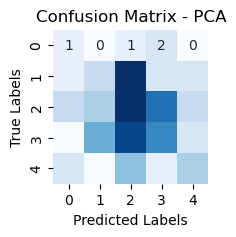

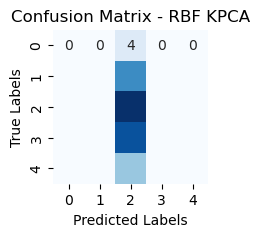

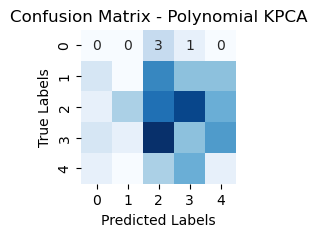

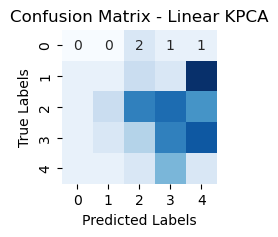

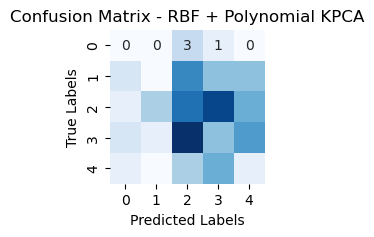

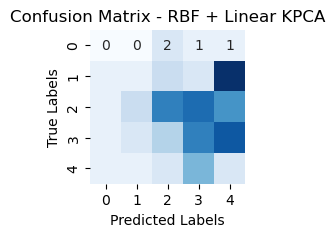

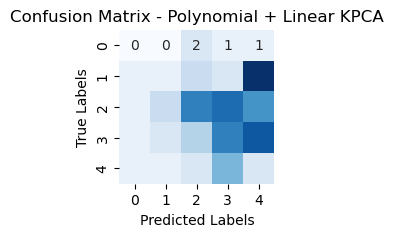

Classification Report - PCA:
              precision    recall  f1-score   support

           0       0.14      0.25      0.18         4
           1       0.23      0.15      0.18        20
           2       0.29      0.39      0.33        31
           3       0.36      0.30      0.33        27
           4       0.36      0.33      0.35        12

    accuracy                           0.30        94
   macro avg       0.28      0.28      0.27        94
weighted avg       0.30      0.30      0.29        94

Classification Report - RBF KPCA:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        20
           2       0.33      1.00      0.50        31
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        12

    accuracy                           0.33        94
   macro avg       0.07      0.20      0.10        94
weighted avg  

C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [225]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Dic with each model's predictions
predictions = {
    "PCA": pca_pred,
    "RBF KPCA": rbf_pred,
    "Polynomial KPCA": poly_pred,
    "Linear KPCA": lin_pred,
    "RBF + Polynomial KPCA": RP_pred,
    "RBF + Linear KPCA": RL_pred,
    "Polynomial + Linear KPCA": PL_pred
}

for model, preds in predictions.items():
    plot_confusion_matrix(y_test, preds, model)

# Optional: printing classification report 
for model, preds in predictions.items():
    print(f"Classification Report - {model}:")
    print(classification_report(y_test, preds))

### Conclusion <a class="anchor" id="last"></a>

**Principal Component Analysis (PCA)**

Implementing PCA from scratch involved computing the covariance matrix, eigenvalues, and eigenvectors to reduce dimensionality while retaining a specified variance threshold. The custom implementation successfully reduced the dataset dimensions from 1880 features to 4 principal components, capturing at least 95% of the variance. In contrast, scikit-learn's PCA required 6 principal components to achieve a similar level of variance retention.

**Kernel PCA (KPCA)**

Kernel PCA extends PCA by using nonlinear kernels to handle complex datasets where linear separation is inadequate. The custom KPCA implementation supported various kernel types (RBF, polynomial, linear, and combined) to project data into a higher-dimensional space where nonlinear relationships can be more effectively captured. For instance, KPCA with an RBF kernel required 443 principal components to capture 95% of the variance. So, even though it can handle nonlinear relationships, it can lead to higher model complexity.

**Effectiveness of Dimensionality Reduction**

PCA and KPCA effectively reduce dimensionality, but their impact on classification performance varies:

- PCA simplifies feature space linearly, making it efficient for datasets with linearly separable classes. It's computationally efficient but may struggle with nonlinear data.
- KPCA is more flexible, capturing nonlinear relationships, but requires tuning kernel parameters and handling larger feature spaces, potentially leading to overfitting or increased computational demands.

**Advantages and Disadvantages of Implementations**

Implementing PCA and KPCA from scratch offers allows for customization. For instance, our implemantation calculated the number of principal components based on a target variance to be retained. However, built-in implementations like scikit-learn's are optimized, well-tested and integrated with other machine learning pipelines, making them more robust. 

**Methodology**

The analysis involved evaluating the effectiveness of various projection techniques in reducing the dimensionality of the dataset, followed by classification using a minimum distance classifier. The projection techniques tested included Principal Component Analysis (PCA), Radial Basis Function Kernel PCA (RBF KPCA), Polynomial Kernel PCA (Polynomial KPCA), Linear Kernel PCA (Linear KPCA), and combinations of these kernel methods. Specifically, the combined projections tested were RBF + Polynomial KPCA, RBF + Linear KPCA, and Polynomial + Linear KPCA. For each projection method, the dataset was divided into training and testing sets, with the training set used to learn the projections and the test set used to evaluate the performance of the projections in a classification task.

**Insights from Combining Different Kernels and Analyzing Covariance Matrix**

The accuracy of the predictions varied significantly across different projection methods, with RBF KPCA achieving the highest accuracy at 32.98%, followed by PCA at 29.79%, and Linear KPCA at 22.34%. The combined kernel methods did not outperform the individual kernel methods, with RBF + Polynomial KPCA achieving an accuracy of 15.96%, and both RBF + Linear KPCA and Polynomial + Linear KPCA achieving 22.34%.

Some possible reasons why the combined kernel projections did not perform better than the individual kernels:

- If one kernel's values are significantly larger than the other, it may dominate the combined kernel, making it almost identical to the dominant one.
- The kernels might be capturing similar patterns in the data, so combining them doesn't add new information.
- Combining them through addition might not be the most effective method. 